In [ ]:
!pip install albumentations
!pip install torchmetrics
!pip install paddleocr>=2.0.1 paddlepaddle
!pip install opencv-python-headless==4.5.3.56
!pip install segmentation_models_pytorch

In [28]:
%%time
## STANDARD LIBRARY AND PIPELINE MODULES IMPORT
import warnings
warnings.filterwarnings("ignore")
from pipeline import segmentation
from pipeline import correct_perspective
# from pipeline import text_detection
from pipeline import OCR
from pipeline import classifier
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 26.5 µs


In [107]:
class Rules:   

    def __init__(self):
        pass

    def _txt_len(self, text):
        ##avoiding string containing long texts as it will be generally something else
        if len(text)>7:
            return False
        return True

    def _is_alpha(self, text):
        ##avoiding string containing alphabets
        if re.search('[a-zA-Z]', text)==None:
            return True
        return False
    def _pre_check(self, text):
        ## pre checking for valid characters
        valid = True
        valid = (self._txt_len(text) and valid)
        valid = (self._is_alpha(text) and valid)
        return valid

    def BPRule(self, text):
        sbp = 0
        dbp = 0
        pos = text.find("/")
        # print("POS - ", pos)
        if pos!=-1:
            sbp = text[max(pos-3, 0):pos]
            dbp = text[pos+1:pos+4]
            return True, [sbp, dbp]
        else:
            return False, None

    def class_pred(self, text):
        valid = self._pre_check(text)
        if valid:
            bp = self.BPRule(text)
            if bp[0]:
                return "BP", [("SBP", bp[1][0]), ("DBP", bp[1][1])]
            else:
                return ""
            
        else:
            return "Invalid text"


ru = Rules()

In [159]:
%%time
## EVALUATION ON EACH IMAGE
TEST_IMG_DIR = "val/BPL-EliteView-EV10-B_Meditec-England-A"
imlis = os.listdir(TEST_IMG_DIR)
imloc = f"{TEST_IMG_DIR}/{imlis[30]}"

image = cv2.cvtColor(cv2.imread(imloc), cv2.COLOR_BGR2RGB)
ocr_io = cv2.resize(image, (320, 180))
class_io = cv2.resize(image, (640, 360))
# mask = segmentation.maskPred(image)
# # print(mask)
# (ocr_io, class_io, orig_io) =  correct_perspective.correctPerspective(image, mask)
label = classifier.classification(class_io) 
if label==1:
    candidates =  OCR.get_text(class_io, det=True)
else:
    print("here")
    candidates =  OCR.get_text(ocr_io, det=True)
can = candidates[0]

result = {}
for line in can:
    bbox = line[0]
    txt = line[1][0]
    confidence = line[1][1]
    # print(bbox, txt, confidence)
    pred = ru.class_pred(txt)
    if len(pred)>0:
        clas = pred[0]
        if(clas=="BP"):
            result[pred[1][0][0]] = pred[1][0][1]
            result[pred[1][1][0]] = pred[1][1][1]
    print(txt ,"-", len(pred))

print(result)

# bounding_boxes1 = list(np.expand_dims(np.round(np.array(bounding_boxes)).astype(np.int32), 2))

# fig, ax = plt.subplots(len(bounding_boxes) + 1, 2, figsize = (40, 200))

# croplis = []
# texlis = []

# for idx in range(len(bounding_boxes)):
#     img = cv2.cvtColor(class_io, cv2.COLOR_BGR2GRAY)
#     # mask = np.zeros_like(img) # Create mask where white is what we want, black otherwise
#     # cv2.drawContours(mask, bounding_boxes1, idx, 255, -1) # Draw filled contour in mask
#     # out = np.zeros_like(img) # Extract out the object and place into output image
#     # out[mask == 255] = img[mask == 255]
    
#     # ax[idx][0].imshow(out)
#     # print(bounding_boxes[idx][0])
#     text, crop = OCR.trOCR(class_io, bounding_boxes[idx])
    
#     # ax[idx][1].imshow(crop)
#     # ax[idx][1].set_xlabel(f"{text}, {len(text)}")
    
#     croplis.append(crop)
#     texlis.append(text)
    
# # ax[-1][0].imshow(image)
# # ax[-1][1].imshow(class_io)

# # fig, ax = plt.subplots(len(bounding_boxes) + 1)

# # for idx,bounding_box in enumerate(bounding_boxes):
# #     text, crop = OCR.trOCR(detector_io, bounding_box)

# #     print(text)
# #     ax[idx].imshow(crop)
# # ax[-1].imshow(monitor)

here
[2023/02/05 13:55:30] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/02/05 13:55:30] ppocr DEBUG: dt_boxes num : 12, elapse : 0.050070762634277344
[2023/02/05 13:55:31] ppocr DEBUG: rec_res num  : 12, elapse : 0.6210284233093262
85 - 0
134/73 - 2
(89) - 0
91 - 0
17 - 0
{'SBP': '134', 'DBP': '73'}
CPU times: user 1.56 s, sys: 5.82 ms, total: 1.57 s
Wall time: 789 ms


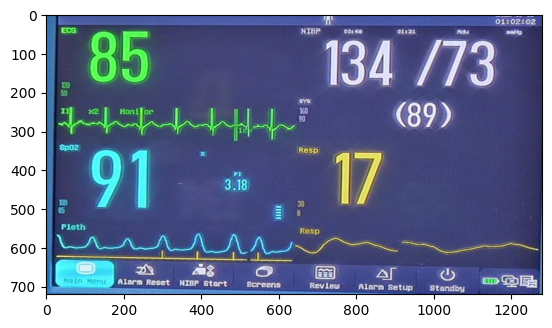

In [160]:
plt.imshow(image)

In [120]:
print(label)

3


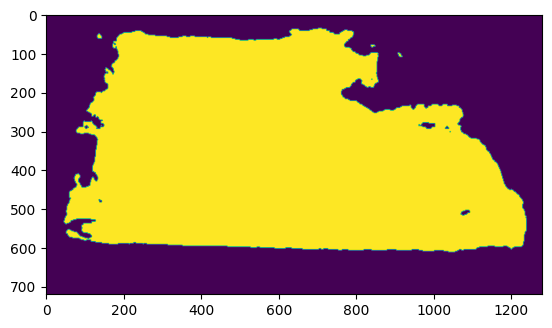

In [66]:
plt.imshow(mask)

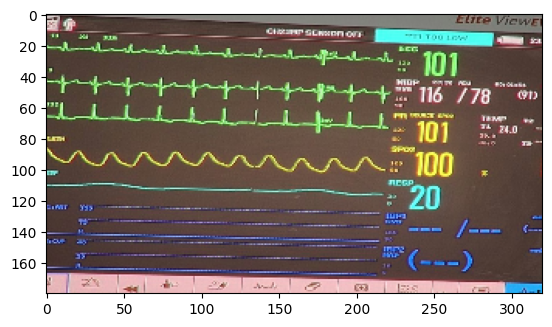

In [79]:
plt.imshow(ocr_io)

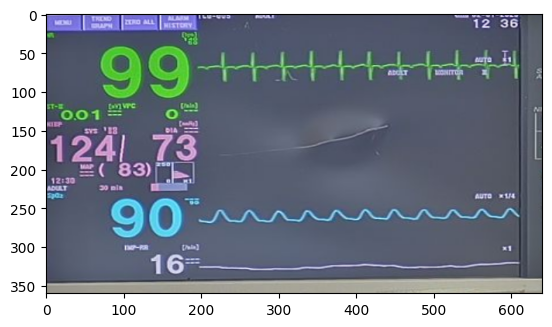

In [6]:
plt.imshow(class_io)

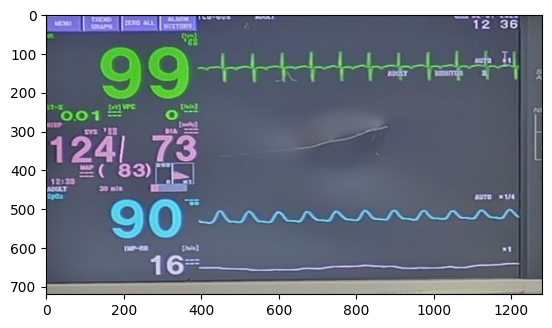

In [7]:
plt.imshow(orig_io)

In [8]:
result=result[0]
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
bounding_boxes1 = list(np.expand_dims(np.round(np.array(boxes)).astype(np.int32), 2))

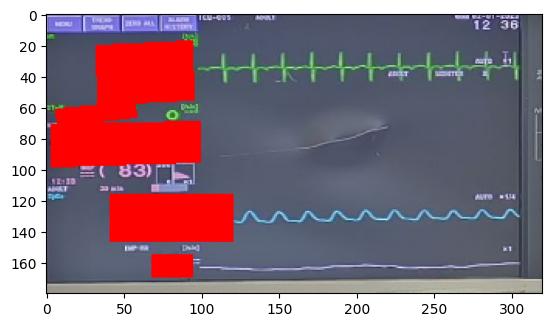

In [9]:
plt.imshow(cv2.drawContours(_io, bounding_boxes1, -1, 255, -1)) # Draw filled contour in mask